# Gravitational Orbits
Programmer: Matthew Kusz 

Last Revision: 04/16/2019

We will be setting up a Lagrangian for the motion of 2 orbital bodies and solving Langrange's equations.

Lagrange's equations are:

$\begin{align}
 \frac{d}{dt}\frac{\partial\mathcal{L}}{\partial \dot q} = \frac{\partial\mathcal L}{\partial q}
\end{align}$

Our Lagrangian is $\mathcal{L}=T-U$ where

$\begin{align}
 T &= \frac{1}{2} (\dot x_1^2 + \dot y_1^2) + \frac{1}{2} (\dot x_2^2 + \dot y_2^2) \\
 U &= \frac{G m_1 m_2}{r}
\end{align}$

Now we need to solve Lagrange's equations for $x_1, y_1, x_2,$ and $y_2$.

$\begin{align}
 \ddot x_1 &= \frac{-G m_1 m_2}{r_{12}^2} \frac{x_1-x_2}{r_{12} m_1} \\
 \ddot y_1 &= \frac{-G m_1 m_2}{r_{12}^2} \frac{y_1-y_2}{r_{12} m_1} \\
 \ddot x_2 &= \frac{-G m_1 m_2}{r_{21}^2} \frac{x_2-x_1}{r_{21} m_2} \\
 \ddot y_2 &= \frac{-G m_1 m_2}{r_{21}^2} \frac{y_2-y_1}{r_{21} m_2}
\end{align}$

We have $r_{12}=\sqrt{(x_1-x_2)^2+(y_1-y_2)^2}=r_{21}$. We are leaving $m_1$ and $m_2$ in th denominator
to match the code.

We can now use these in our solve_ivp to find $[x_1,\dot x_1, y_1, \dot y_1, x_2, \dot x_2, y_2, \dot y_2]$ 
and plot the motion.

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [76]:
# Change the common font size
font_size = 14
plt.rcParams.update({'font.size': font_size})

In [77]:
class Orbit():
    """
    Potentials and associated differential equations for a gravitationally
    bound system. We will use the solve_ivp method for integration
    of ordinary differential equations. 
    
    Parameters
    ----------
    m1 : float
        mass of the first orbital body
    m2 : float
        mass of the second prbital body
    G: gravitational constant

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
        
    """
    def __init__(self, m1, m2, G):
        self.m1 = m1
        self.m2 = m2
        self.G = G
        
    def dy_dt(self, t, y):
        """
        This function returns the right-hand side of the diffeq: 
        [dx1/dt d^2x1/dt^2 dy1/dt d^2y1/dt^2 dx2/dt d^2x2/dt^2 dy2/dt d^2y2/dt^2]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            8-component vector with y[0] = x1, y[1] = x1_dot, y[2] = y1, y[3] = y1_dot, 
            y[4] = x2, y[5] = x2_dot, y[6] = y2, y[7] = y2_dot
            
        """
        r = np.sqrt((y[0]-y[4])**2 + (y[2]-y[6])**2)
        F = -self.G*self.m1*self.m2/r**2
        
        return [y[1], F*(y[0]-y[4])/(self.m1*r), y[3], F*(y[2]-y[6])/(self.m1*r), 
                y[5], F*(y[4]-y[0])/(self.m2*r), y[7], F*(y[6]-y[2])/(self.m2*r)]
        
    def solve_ode(self, x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0,
                  t, abserr = 1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        
        y = [x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0]
        
        solution = solve_ivp(self.dy_dt, (t[0], t[-1]), y, t_eval=t, rtol=relerr, atol=abserr)
            # solve_ivp( function for rhs with (t, y) argument (cf. (y,t) for odeint), 
            #            tspan=(starting t value, ending t value),
            #            initial value of y(t), array of points we want to know y(t),
            #            method='RK45' is the default method,
            #            rtol=1.e-3, atol=1.e-6 are default tolerances
            #          )
            
        x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = solution.y
        
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot        
 
    def solve_ode_Leapfrog(self, x1_0, x1_dot_0, y1_0, y1_dot_0, x2_0, x2_dot_0, y2_0, y2_dot_0, t_pts):
        """
        Solve the ODE given initial conditions with the Leapfrog method.
        """
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the arrays for r, rdot, r_dot_half, phi with zeros
        num_t_pts = len(t_pts)
        x1 = np.zeros(num_t_pts)
        x1_dot = np.zeros(num_t_pts)
        x1_dot_half = np.zeros(num_t_pts)

        y1 = np.zeros(num_t_pts)
        y1_dot = np.zeros(num_t_pts)
        y1_dot_half = np.zeros(num_t_pts)
        
        x2 = np.zeros(num_t_pts)
        x2_dot = np.zeros(num_t_pts)
        x2_dot_half = np.zeros(num_t_pts)
        
        y2 = np.zeros(num_t_pts)
        y2_dot = np.zeros(num_t_pts)
        y2_dot_half = np.zeros(num_t_pts)
        
        # initial conditions
        x1[0] = x1_0
        x1_dot[0] = x1_dot_0
        
        y1[0] = y1_0
        y1_dot[0] = y1_dot_0
        
        x2[0] = x2_0
        x2_dot[0] = x2_dot_0
        
        y2[0] = y2_0
        y2_dot[0] = y2_dot_0
        """
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            x1_dot_half[i] = x1_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y1_dot_half[i] = y1_dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y1[i+1] = x1[i] + y1_dot_half[i] * delta_t
            
            x2_dot_half[i] = x2_dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x2[i+1] = x1[i] + x2_dot_half[i] * delta_t
            
            y2_dot_half[i] = y2_dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y2[i+1] = x1[i] + y2_dot_half[i] * delta_t
            
            y = [x1[i+1], x1_dot[i], y1[i+1], y1_dot[i], x2[i+1], x2_dot[i], y2[i+1], y2_dot[i]]
            x1_dot[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            
            y1_dot[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            
            x2_dot[i+1] = x2_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            
            y2_dot[i+1] = y2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.
        """
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            x1_dot_half[i] = x1_dot[i] + self.dy_dt(t, y)[1] * delta_t/2.
            x1[i+1] = x1[i] + x1_dot_half[i] * delta_t
            
            y = [x1[i+1], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            x1_dot[i+1] = x1_dot_half[i] + self.dy_dt(t, y)[1] * delta_t/2.
            
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            y1_dot_half[i] = y1_dot[i] + self.dy_dt(t, y)[3] * delta_t/2.
            y1[i+1] = y1[i] + y1_dot_half[i] * delta_t
            
            y = [x1[i], x1_dot[i], y1[i+1], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            y1_dot[i+1] = y1_dot_half[i] + self.dy_dt(t, y)[3] * delta_t/2.
            
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            x2_dot_half[i] = x2_dot[i] + self.dy_dt(t, y)[5] * delta_t/2.
            x2[i+1] = x2[i] + x2_dot_half[i] * delta_t
            
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i+1], x2_dot[i], y2[i], y2_dot[i]]
            x2_dot[i+1] = x2_dot_half[i] + self.dy_dt(t, y)[5] * delta_t/2.
            
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i], y2_dot[i]]
            y2_dot_half[i] = y2_dot[i] + self.dy_dt(t, y)[7] * delta_t/2.
            y2[i+1] = y2[i] + y2_dot_half[i] * delta_t
            
            y = [x1[i], x1_dot[i], y1[i], y1_dot[i], x2[i], x2_dot[i], y2[i+1], y2_dot[i]]
            y2_dot[i+1] = y2_dot_half[i] + self.dy_dt(t, y)[7] * delta_t/2.
                        
        return x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot  

In [78]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

# Gravitational System

In [79]:
# Set up our system
G = 1.
m1 = 10.
m2 = 10.

# Initial conditions (make sure the velocity of the COM frame is zero)
x1_0=-3.5
x1_dot_0 = -0.5
y1_0= 0.
y1_dot_0 = 1.
x2_0= 1.5
x2_dot_0 = -(m1/m2)*x1_dot_0
y2_0= -1.5
y2_dot_0 = -(m1/m2)*y1_dot_0

# Instantiate the orbit
o1 = Orbit(m1=m1, m2=m2, G=G)

In [80]:
# Plotting time 
t_start = 0.
t_end = 100.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

# Find the motions
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode(x1_0, x1_dot_0, y1_0, y1_dot_0, 
                              x2_0, x2_dot_0, y2_0, y2_dot_0, t_pts)

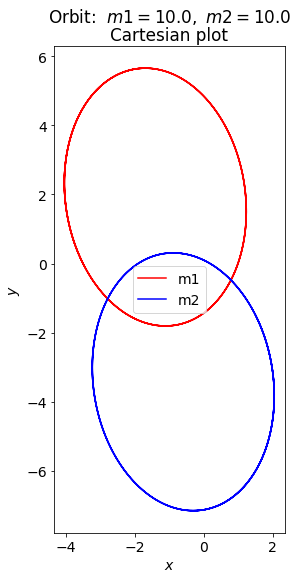

In [81]:
# Plot the points we found
fig_1 = plt.figure(figsize=(8,8))

overall_title = 'Orbit: ' + \
                rf' $m1 = {o1.m1},$' + \
                rf' $m2 = {o1.m2}$'
fig_1.suptitle(overall_title, va='baseline')

ax_1 = fig_1.add_subplot(1,1,1)
ax_1.plot(x1, y1, color='red', label='m1')
ax_1.plot(x2, y2, color='blue', label='m2')
ax_1.set_xlabel(r'$x$')
ax_1.set_ylabel(r'$y$')
ax_1.set_aspect('equal')
ax_1.set_title('Cartesian plot')
ax_1.legend()


fig_1.tight_layout()
fig_1.savefig('Orbits.png', dpi = 200, bbox_inches='tight')  # always bbox_inches='tight

# Large m1

Let's see what happens when m1>>m2.

In [90]:
# Set up our system
G = 1.
m1 = 1000.
m2 = 10.

# Initial conditions (make sure the velocity of the COM frame is zero)
x1_0=-1.5
x1_dot_0 = 0.002
y1_0= 0.
y1_dot_0 = 0.1
x2_0= 1.5
x2_dot_0 = -(m1/m2)*x1_dot_0
y2_0= -2.5
y2_dot_0 = -(m1/m2)*y1_dot_0

# Instantiate the orbit
o1 = Orbit(m1=m1, m2=m2, G=G)

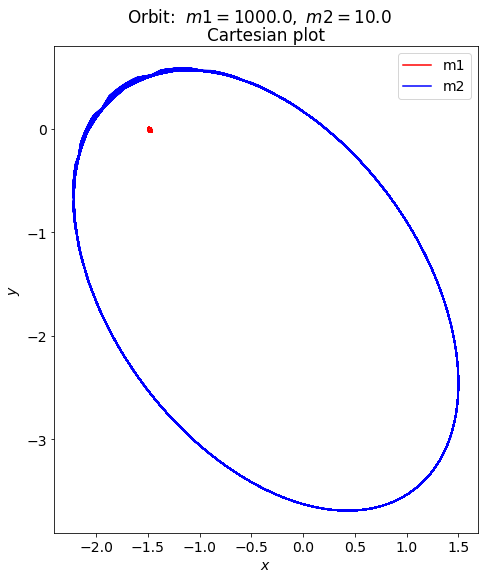

In [91]:
# Find the motions
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode(x1_0, x1_dot_0, y1_0, y1_dot_0, 
                              x2_0, x2_dot_0, y2_0, y2_dot_0, t_pts)

# Plot the points we found
fig_2 = plt.figure(figsize=(8,8))

overall_title = 'Orbit: ' + \
                rf' $m1 = {o1.m1},$' + \
                rf' $m2 = {o1.m2}$'
fig_2.suptitle(overall_title, va='baseline')

ax_2 = fig_2.add_subplot(1,1,1)
ax_2.plot(x1, y1, color='red', label='m1')
ax_2.plot(x2, y2, color='blue', label='m2')
ax_2.set_xlabel(r'$x$')
ax_2.set_ylabel(r'$y$')
ax_2.set_aspect('equal')
ax_2.set_title('Cartesian plot')
ax_2.legend()


fig_2.tight_layout()
fig_2.savefig('Orbits_large_m1.png', dpi = 200, bbox_inches='tight')  # always bbox_inches='tight

In [92]:
x1, x1_dot, y1, y1_dot, x2, x2_dot, y2, y2_dot = o1.solve_ode_Leapfrog(x1_0, x1_dot_0, y1_0, y1_dot_0, 
                              x2_0, x2_dot_0, y2_0, y2_dot_0, t_pts)

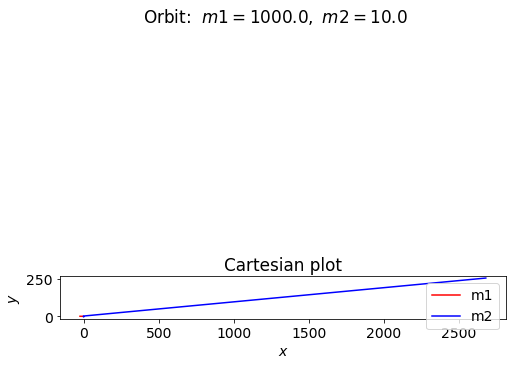

In [93]:
# Plot the points we found
fig_2 = plt.figure(figsize=(8,8))

overall_title = 'Orbit: ' + \
                rf' $m1 = {o1.m1},$' + \
                rf' $m2 = {o1.m2}$'
fig_2.suptitle(overall_title, va='baseline')

ax_2 = fig_2.add_subplot(1,1,1)
ax_2.plot(x1, y1, color='red', label='m1')
ax_2.plot(x2, y2, color='blue', label='m2')
ax_2.set_xlabel(r'$x$')
ax_2.set_ylabel(r'$y$')
ax_2.set_aspect('equal')
ax_2.set_title('Cartesian plot')
ax_2.legend()